In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sb
from scipy.sparse.linalg import eigsh
from scipy import io, signal
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from utils import *
from models import *

## Image dataset

In [59]:
mt = io.loadmat('calcium_data/V1/images_natimg2800_all.mat')
dataset = mt['imgs']  # 68 by 270 by number of images
dataset = np.transpose(dataset, (2,0,1))[:,3:-3,92:(270-92),np.newaxis]#[:,:,93:(270-93)]
dataset = dataset/255.

In [60]:
dataset.shape

(2800, 62, 86, 1)

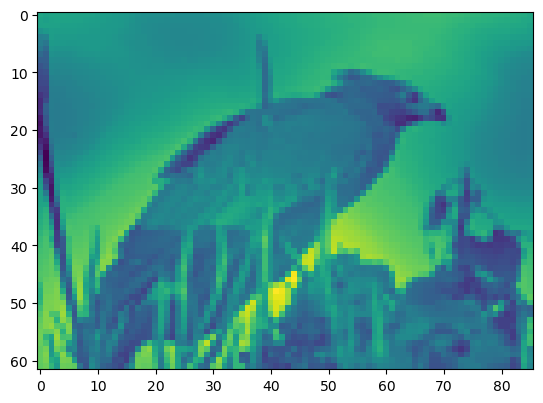

In [61]:
plt.imshow(dataset[120])

In [62]:
def create_dataloader(dataset, batch_size=256, reshuffle_after_epoch=True):
    '''
    Creates a DataLoader for Pytorch to train the autoencoder with the image data converted to a tensor.

    Args:
        dataset (4D numpy array): image dataset with shape (n_samples, n_channels, n_pixels_height, n_pixels_width).
        batch_size (int; default=32): the size of the batch updates for the autoencoder training.

    Returns:
        DataLoader (Pytorch DataLoader): dataloader that is ready to be used for training an autoencoder.
    '''
    if dataset.shape[-1] <= 3:
        dataset = np.transpose(dataset, (0,3,1,2))
    tensor_dataset = TensorDataset(torch.from_numpy(dataset).float(), torch.from_numpy(dataset).float())
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=reshuffle_after_epoch)

In [63]:
train_loader = create_dataloader(dataset, batch_size=256, reshuffle_after_epoch=True)

## Model

In [64]:
class Conv_AE(nn.Module):
    def __init__(self, n_hidden=100):
        super().__init__()

        self.n_hidden = n_hidden
        #self.dim1, self.dim2 = 8, 33
        self.dim1, self.dim2 = 7, 10

        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * self.dim1 * self.dim2, n_hidden)

        # Decoder
        self.fc2 = nn.Linear(n_hidden, 64 * self.dim1 * self.dim2)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.conv5 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, output_padding=0)

    def encoder(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))  
        x = x.view(-1, 64 * self.dim1 * self.dim2)  
        x = F.relu(self.fc1(x))
        return x

    def decoder(self, x):
        # Decoder
        x = F.relu(self.fc2(x)) 
        x = x.view(-1, 64, self.dim1, self.dim2) 
        x = F.relu(self.conv4(x)) 
        x = F.relu(self.conv5(x))  
        x = torch.sigmoid(self.conv6(x))  
        return x

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

    def backward(self, optimizer, criterion, x, y_true, alpha=0, beta=0):

        optimizer.zero_grad()

        y_pred, hidden = self.forward(x)
        recon_loss = criterion(y_pred, y_true)

        whitening_loss = 0
        sparsity_loss = 0
        batch_size, hidden_dim = hidden.shape
        if alpha != 0:
            C = torch.eye(hidden_dim, device='cuda') - torch.mm(hidden.t(), hidden)
            whitening_loss = alpha * torch.norm(C) / (batch_size*hidden_dim)
            
        if beta != 0:
            sparsity_loss = beta * torch.sum(torch.abs(hidden)) / (batch_size*hidden_dim)
        
        loss = recon_loss + whitening_loss + sparsity_loss
        loss.backward()

        optimizer.step()

        return recon_loss.item()

In [94]:
model = Conv_AE(n_hidden=1000)

## Training

In [95]:
def train_autoencoder(model, train_loader, num_epochs=1000, learning_rate=1e-5, alpha=0, beta=0):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    criterion = nn.MSELoss()

    model = model.to('cuda')

    history = []
    for epoch in range(num_epochs):
        running_loss = 0.
        with tqdm(total=len(train_loader)) as pbar:
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                inputs = inputs.to('cuda')

                loss = model.backward(optimizer=optimizer, criterion=criterion, x=inputs, y_true=inputs, alpha=alpha, beta=beta)
                running_loss += loss

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

        history.append(running_loss/len(train_loader))

    return history

In [96]:
history = train_autoencoder(model, train_loader, num_epochs=5000, learning_rate=1e-4, alpha=0, beta=0)

Epoch 64/5000, Loss: 0.0070: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.00it/s]


Epoch 128/5000, Loss: 0.0056: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.48it/s]


Epoch 192/5000, Loss: 0.0050: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.56it/s]


Epoch 256/5000, Loss: 0.0045: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.87it/s]


Epoch 320/5000, Loss: 0.0043: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.19it/s]


Epoch 384/5000, Loss: 0.0040: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.52it/s]


Epoch 448/5000, Loss: 0.0038: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.25it/s]


Epoch 512/5000, Loss: 0.0037: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.56it/s]


Epoch 576/5000, Loss: 0.0035: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.71it/s]


Epoch 640/5000, Loss: 0.0034: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.31it/s]


Epoch 704/5000, Loss: 0.0033: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.75it/s]


Epoch 768/5000, Loss: 0.0032: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.90it/s]


Epoch 832/5000, Loss: 0.0031: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.49it/s]


Epoch 896/5000, Loss: 0.0030: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.05it/s]


Epoch 960/5000, Loss: 0.0029: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.16it/s]


Epoch 1024/5000, Loss: 0.0029: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.40it/s]


Epoch 1088/5000, Loss: 0.0028: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.65it/s]


Epoch 1152/5000, Loss: 0.0028: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.90it/s]


Epoch 1216/5000, Loss: 0.0027: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.93it/s]


Epoch 1280/5000, Loss: 0.0026: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.92it/s]


Epoch 1344/5000, Loss: 0.0026: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.95it/s]


Epoch 1408/5000, Loss: 0.0025: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.36it/s]


Epoch 1472/5000, Loss: 0.0025: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.82it/s]


Epoch 1536/5000, Loss: 0.0024: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.93it/s]


Epoch 1600/5000, Loss: 0.0024: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.81it/s]


Epoch 1664/5000, Loss: 0.0024: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.89it/s]


Epoch 1728/5000, Loss: 0.0023: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.56it/s]


Epoch 1792/5000, Loss: 0.0023: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.14it/s]


Epoch 1856/5000, Loss: 0.0023: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.47it/s]


Epoch 1920/5000, Loss: 0.0023: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.63it/s]


Epoch 1984/5000, Loss: 0.0022: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.04it/s]


Epoch 2048/5000, Loss: 0.0022: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.74it/s]


Epoch 2112/5000, Loss: 0.0022: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.23it/s]


Epoch 2176/5000, Loss: 0.0021: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.37it/s]


Epoch 2240/5000, Loss: 0.0021: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.45it/s]


Epoch 2304/5000, Loss: 0.0021: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.63it/s]


Epoch 2368/5000, Loss: 0.0021: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.41it/s]


Epoch 2432/5000, Loss: 0.0021: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.76it/s]


Epoch 2496/5000, Loss: 0.0021: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.82it/s]


Epoch 2560/5000, Loss: 0.0020: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.98it/s]


Epoch 2624/5000, Loss: 0.0020: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.96it/s]


Epoch 2688/5000, Loss: 0.0020: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.93it/s]


Epoch 2752/5000, Loss: 0.0020: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.61it/s]


Epoch 2816/5000, Loss: 0.0020: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.02it/s]


Epoch 2880/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.77it/s]


Epoch 2944/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.13it/s]


Epoch 3008/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.43it/s]


Epoch 3072/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.16it/s]


Epoch 3136/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.58it/s]


Epoch 3200/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.61it/s]


Epoch 3264/5000, Loss: 0.0019: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.38it/s]


Epoch 3328/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.59it/s]


Epoch 3392/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.33it/s]


Epoch 3456/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.60it/s]


Epoch 3520/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.31it/s]


Epoch 3584/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.88it/s]


Epoch 3648/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.82it/s]


Epoch 3712/5000, Loss: 0.0018: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.78it/s]


Epoch 3776/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.08it/s]


Epoch 3840/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.32it/s]


Epoch 3904/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.04it/s]


Epoch 3968/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.38it/s]


Epoch 4032/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.28it/s]


Epoch 4096/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.70it/s]


Epoch 4160/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.99it/s]


Epoch 4224/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.05it/s]


Epoch 4288/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.51it/s]


Epoch 4352/5000, Loss: 0.0017: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.26it/s]


Epoch 4416/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.87it/s]


Epoch 4480/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.76it/s]


Epoch 4544/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.46it/s]


Epoch 4608/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.04it/s]


Epoch 4672/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.55it/s]


Epoch 4736/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.12it/s]


Epoch 4800/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.84it/s]


Epoch 4864/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.08it/s]


Epoch 4928/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.76it/s]


Epoch 4992/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.93it/s]


Epoch 5000/5000, Loss: 0.0016: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.37it/s]


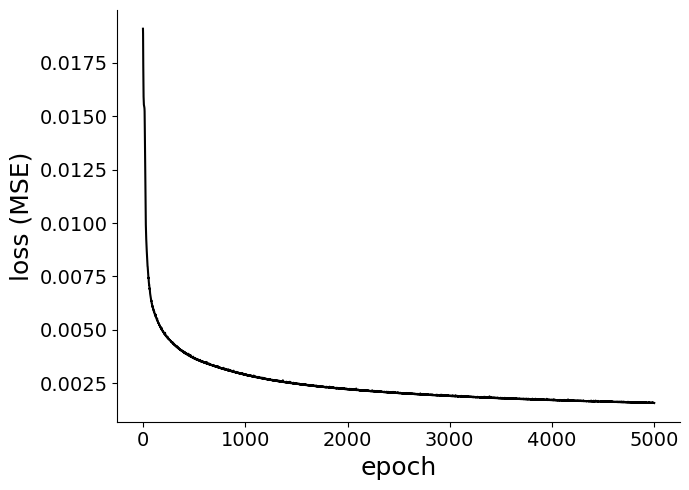

In [97]:
plt.figure(figsize=(7,5))

plt.plot(history, color='black')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss (MSE)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sb.despine()
plt.tight_layout()

#plt.savefig('plots/loss.png', dpi=600)
plt.show()

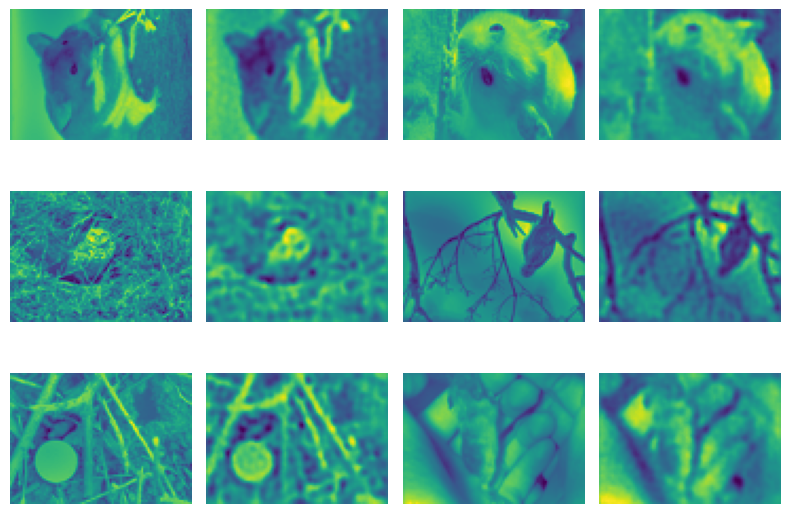

In [98]:
plt.figure(figsize=(8,6))

indxs = np.random.randint(0, 1000, 6)

for i in range(12):
    plt.subplot(3,4,i+1)
    if i%2==0:
        plt.imshow(dataset[indxs[int(i/2)]])
    else:
        plt.imshow(predict(dataset[indxs[int(i/2)]], model))
    plt.axis('off')

plt.tight_layout()
#plt.savefig('plots/reconstructed_imgs.png', dpi=600)
plt.show()

## Power-law and pairwise correlations

In [99]:
embeddings = get_latent_vectors(dataset, model)

In [ ]:
embeddings_reduced = PCA().fit(embeddings)
variances = embeddings_reduced.explained_variance_ratio_

In [109]:
start_fit = 10
cutoff_fit = 200
x = np.arange(1, len(variances)+1)
y = variances
m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)

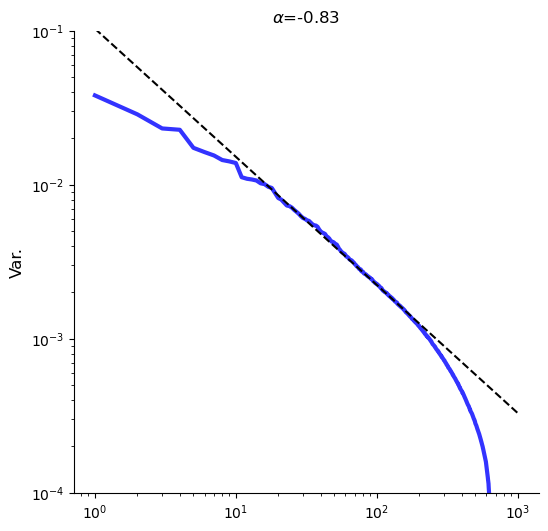

In [110]:
plt.figure(figsize=(6,6))

plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)

x_fit = x
y_fit = np.exp(b) * x_fit**m
plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)

if i >= (10-1)*11-2:
    plt.xlabel('PC dim.', fontsize=12)
if i%11==0: 
    plt.ylabel('Var.', fontsize=12)
plt.xscale('log')
plt.yscale('log')

#plt.xlim(0,350)
plt.ylim(1e-4,1e-1)

sb.despine()

#plt.savefig('plots/calciumData_powerLawFits.png', dpi=600)

plt.show()

In [102]:
from scipy.stats import pearsonr

def compute_pairwise_correlations(data):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    n_neurons = data.shape[1]
    correlations = []
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            corr, p_value = pearsonr(data[:, i], data[:, j])
            correlations.append(corr)

    return correlations

In [103]:
correlations = compute_pairwise_correlations(embeddings)

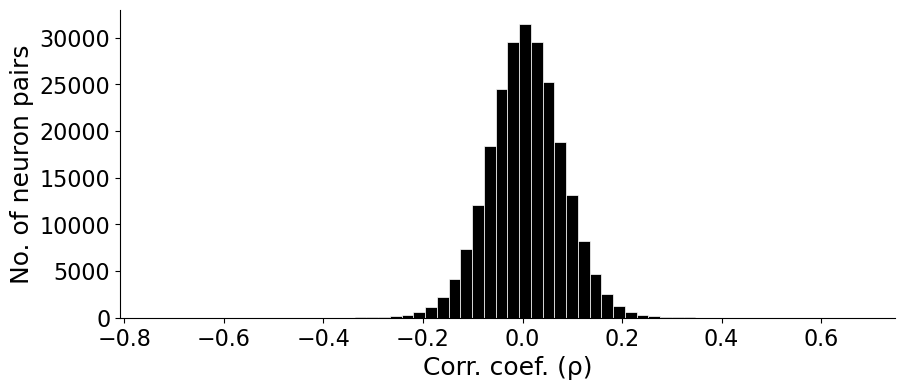

In [104]:
plt.figure(figsize=(10,4))

plt.hist(correlations, bins=60, color='k', alpha=1, edgecolor='white', linewidth=.5)

#plt.axvline(x=np.nanmean(correlations_nonortho), color='k', linestyle='--')

plt.xlabel('Corr. coef. (ρ)', fontsize=18)
plt.ylabel('No. of neuron pairs', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-0.05, 0.1)

sb.despine()
#plt.savefig('plots/pairwiseCorrDistr.png', dpi=600)
plt.show()